In [ ]:
from ib_insync import *
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

util.startLoop()

ib = IB()
ib.connect()

In [ ]:
# Set up the contracts
box_contract = Stock('BOX', 'SMART', 'USD')
dropbox_contract = Stock('DBX', 'SMART', 'USD')

try:
    ib.qualifyContracts(box_contract)
    ib.qualifyContracts(dropbox_contract)
except Exception as e:
    print(e)

In [ ]:
# Create ticker dataframes
box_df = pd.DataFrame(columns=['date', 'last'])
box_df.set_index('date', inplace=True)

dropbox_df = pd.DataFrame(columns=['date', 'last'])
dropbox_df.set_index('date', inplace=True)

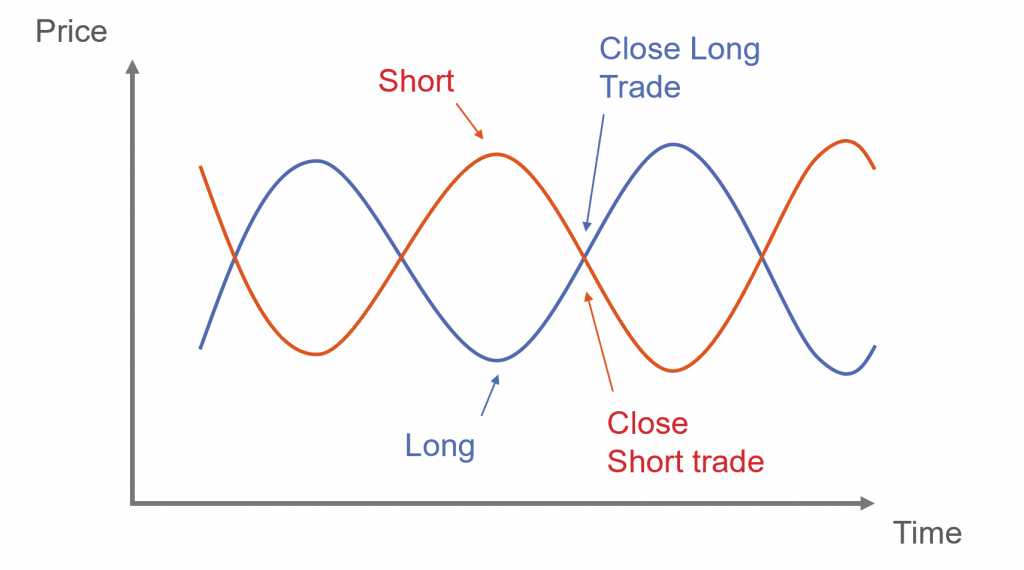

In [ ]:
def new_data(tickers):
    ''' process incoming data and check for trade entry ''' 
    for ticker in tickers:
        if ticker.contract.symbol == 'BOX':
            box_df.loc[ticker.time] = ticker.last
            
        if ticker.contract.symbol == 'DBX':
            dropbox_df.loc[ticker.time] = ticker.last      
    
    five_days_ago_box = box_df.index[-1] - pd.Timedelta(days=5)
    five_days_ago_dropbox = dropbox_df.index[-1] - pd.Timedelta(days=5)
    
    box_first_close = box_df[five_days_ago_box:]['last']
    box_latest_close = box_df['last'][-1]
    
    dropbox_first_close = dropbox_df[five_days_ago_dropbox:]['last']
    dropbox_latest_close = dropbox_df['last'][-1]
        
    box_percentage_move = (box_latest_close - box_first_close)/box_first_close*100
    dropbox_percentage_move = (dropbox_latest_close - dropbox_first_close)/dropbox_first_close*100
    divergance = box_percentage_move[0] - dropbox_percentage_move[0]
    
    print(f'BOX movement at {box_percentage_move[0]}\nDBX movement at {dropbox_percentage_move[0]}')
    
    if divergance < -5.0:
        print(f'Trade Signal: BOX diverged {divergance} from DBX')
        place_order('BUY')
        ib.disconnect()

    elif divergance > 5.0:
        print(f'Trade Signal: BOX diverged {divergance} from DBX')
        place_order('SELL')
        ib.disconnect()

In [ ]:
def place_order(direction):
    ''' place order with IB and exit script if order gets filled '''
    if direction == 'BUY':
        box_order = MarketOrder(direction, 20)
        dropbox_order = MarketOrder('SELL', 20)
        
        try:
            trade_dropbox = ib.placeOrder(dropbox_contract, dropbox_order)
            trade_box = ib.placeOrder(box_contract, box_order)
        except Exception as e:
            print(e)
            
        print('Orders executed.')
        
    elif direction == 'SELL':
        dropbox_order = MarketOrder(direction, 20)
        box_order = MarketOrder('BUY', 20)
        
        try:
            trade_box = ib.placeOrder(box_contract, box_order)
            trade_dropbox = ib.placeOrder(dropbox_contract, dropbox_order)
        except Exception as e:
            print(e)
            
        print('Orders executed.')

In [ ]:
try:
    # Get market data
    ib.reqMarketDataType(3)
    ib.reqMktData(dropbox_contract)
    ib.reqMktData(box_contract)

    # Set callback function for tick data
    ib.pendingTickersEvent += new_data
    
    # Start trading
    ib.run()
except Exception as e:
    print(e)